## Train LSTM model for power and energy prediction

In [ ]:
%pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00


### 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import mlflow
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import matplotlib.pyplot as plt
import os

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f"GPU is available and will be used: {gpus}")
else:
    print("No GPU detected, using CPU")

GPU is available and will be used: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2: Define Hyperparameters

In [ ]:
# Hyperparameters (previously handled by argparse)
csv_path = "china_mill_data_2025_03_04_09_30_30.csv"  # Replace with your actual CSV path
window_size = 3360  # Input window size (e.g., 7 days = 3360)
batch_size = 32
hidden_size = 64
num_layers = 2
epochs = 50
features = ['energy']  # Define features here as they were hardcoded
learning_rate = 0.001
model_name = "china_mill"

### 3: Data Loading and Preprocessing Function

In [ ]:
def load_and_preprocess_data(csv_path, features, window_size):
    print(f"Loading data from {csv_path}")
    df = pd.read_csv(csv_path, parse_dates=['time'])
    df = df.sort_values('time').set_index('time')
    df = df[features]

    # Store original energy for comparison
    original_energy = df['energy'].copy()

    # Handle zero values in energy (keeping initial zeros)
    print("Processing zero values in energy")
    energy = df['energy'].copy()
    mask = energy == 0

    # Keep initial zeros until first non-zero value
    first_nonzero_idx = energy.ne(0).idxmax()
    mask.loc[:first_nonzero_idx] = False

    # Replace subsequent zeros with previous non-zero value
    if mask.any():
        energy.loc[mask] = np.nan
        energy = energy.ffill()  # Updated to use ffill() instead of fillna(method='ffill')
    df['energy'] = energy

    # Fill any remaining NaN values
    df = df.ffill()  # Updated to use ffill() instead of fillna(method='ffill')

    # Plot original vs filtered energy
    print("Plotting original vs filtered energy")
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, original_energy, label='Original Energy', alpha=0.5, linestyle='--')
    plt.plot(df.index, df['energy'], label='Filtered Energy', alpha=0.5)
    plt.title('Original vs Filtered Energy Values')
    plt.xlabel('Time')
    plt.ylabel('Energy Value')
    plt.legend()
    plt.grid(True)
    plt.show()  # Display the plot instead of saving

    print("Scaling data")
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size:i])
        y.append(scaled_data[i])

    print("Creating input sequences")
    X = np.array(X)
    y = np.array(y)
    return X, y, scaler

### 4: Model Building Function

In [ ]:
# Custom callback for MLflow logging per epoch
class MLflowLoggingCallback(Callback):
    def __init__(self, save_dir="checkpoints"):
        super().__init__()
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Log metrics to MLflow
        mlflow.log_metric("train_loss", logs.get('loss'), step=epoch)
        mlflow.log_metric("train_mae", logs.get('mae'), step=epoch)
        mlflow.log_metric("val_loss", logs.get('val_loss'), step=epoch)
        mlflow.log_metric("val_mae", logs.get('val_mae'), step=epoch)
        mlflow.log_metric("val_mse", logs.get('val_mse'), step=epoch)

        # Save model at the end of each epoch
        model_path = os.path.join(self.save_dir, f"model_epoch_{epoch+1}.keras")
        self.model.save(model_path)
        # Optionally log model file to MLflow artifacts
        mlflow.log_artifact(model_path, artifact_path="models")

In [ ]:
def build_model(input_shape, hidden_size, num_layers, output_size, learning_rate):
    print("Building LSTM model")
    model = Sequential()
    model.add(LSTM(hidden_size, return_sequences=(num_layers > 1), input_shape=input_shape))
    for _ in range(1, num_layers):
        model.add(LSTM(hidden_size, return_sequences=(_ < num_layers - 1)))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(output_size))

    # Custom optimizer with specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    return model

In [ ]:
# Start MLflow run
mlflow.start_run()

# Log hyperparameters
mlflow.log_params({
    "window_size": window_size,
    "batch_size": batch_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "epochs": epochs
})

### 5: Data Preparation

Loading data from china_mill_data_2025_03_04_09_30_30.csv
Processing zero values in energy
Plotting original vs filtered energy


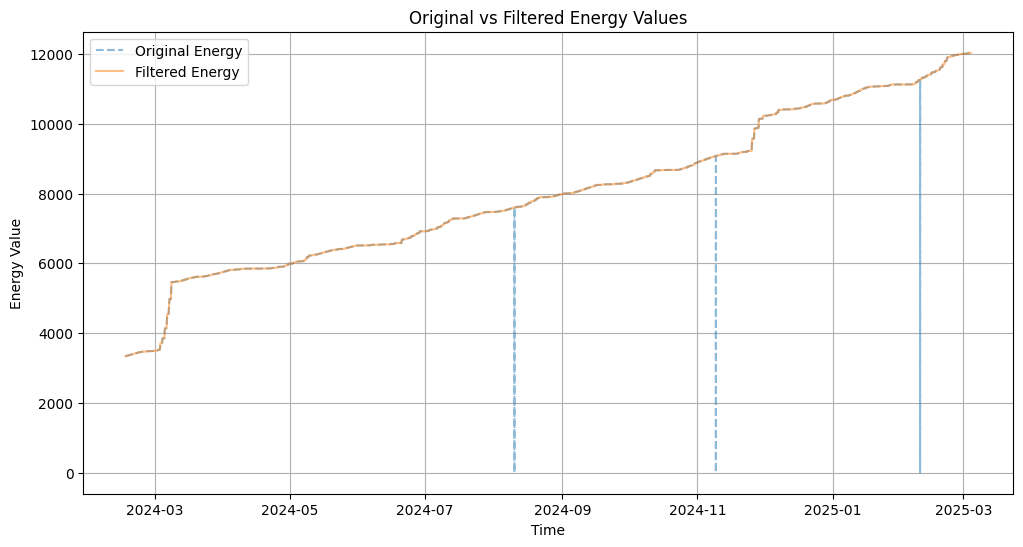

Scaling data
Creating input sequences
Training data shape: (101312, 3360, 1), (101312, 1)
Testing data shape: (25328, 3360, 1), (25328, 1)


In [ ]:
# Load and preprocess data
X, y, scaler = load_and_preprocess_data(csv_path, features, window_size)

# Split into train and test sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Print shapes for verification
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

### 6: Model Creation and Training

In [ ]:
# Learning rate scheduler
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

In [ ]:
# Build the model
model = build_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=len(features),
    learning_rate=learning_rate
)

Building LSTM model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3360, 64)       │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,145 (211.50 KB)

 Trainable params: 54,145 (211.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mlflow_callback = MLflowLoggingCallback()

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, lr_schedule, mlflow_callback]
)

Epoch 1/50
3166/3166 ━━━━━━━━━━━━━━━━━━━━ 672s 211ms/step - loss: 0.0024 - mae: 0.0094 - mse: 0.0024 - val_loss: 3.2107e-05 - val_mae: 0.0046 - val_mse: 3.2107e-05 - learning_rate: 0.0010
Epoch 2/50
3166/3166 ━━━━━━━━━━━━━━━━━━━━ 667s 211ms/step - loss: 8.4877e-06 - mae: 0.0017 - mse: 8.4877e-06 - val_loss: 2.7383e-05 - val_mae: 0.0046 - val_mse: 2.7383e-05 - learning_rate: 0.0010
Epoch 3/50
3166/3166 ━━━━━━━━━━━━━━━━━━━━ 667s 211ms/step - loss: 7.6030e-06 - mae: 0.0015 - mse: 7.6030e-06 - val_loss: 6.8571e-06 - val_mae: 0.0020 - val_mse: 6.8571e-06 - learning_rate: 0.0010
Epoch 4/50
3166/3166 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 9.7280e-06 - mae: 0.0017 - mse: 9.7280e-06
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3166/3166 ━━━━━━━━━━━━━━━━━━━━ 667s 211ms/step - loss: 9.7267e-06 - mae: 0.0017 - mse: 9.7267e-06 - val_loss: 5.0511e-06 - val_mae: 0.0016 - val_mse: 5.0511e-06 - learning_rate: 0.0010
Epoch 5/50
3166/3166 ━━━━━━━━━━━━━━━━━━━━ 668s 211ms

In [ ]:
# Evaluate the model
loss, mae, mse = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae} Test MSE: {mse}")

# Log metrics to MLflow
mlflow.log_metrics({"loss": loss, "mae": mae, "mse": mse})

792/792 ━━━━━━━━━━━━━━━━━━━━ 73s 92ms/step - loss: 1.2147e-06 - mae: 0.0010 - mse: 1.2147e-06
Test Loss: 1.3094360156173934e-06, Test MAE: 0.000989953288808465 Test MSE: 1.3094360156173934e-06


### 7: Model Evaluation and Saving

In [ ]:
# Save the model
model_path = Path(f"{model_name}.keras")
model.save(model_path)
mlflow.log_artifact(str(model_path))

# End MLflow run
mlflow.end_run()

print("Model training and saving completed")

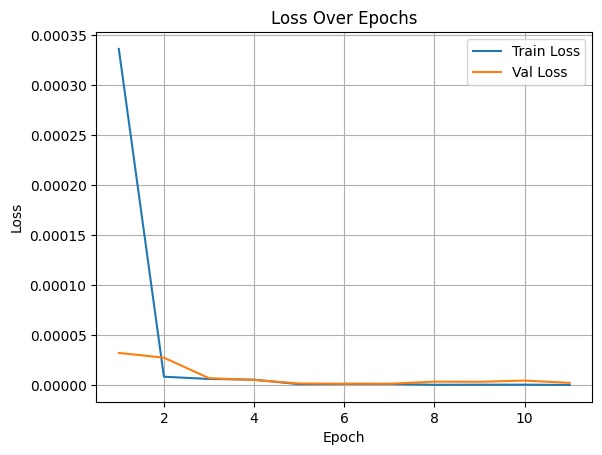

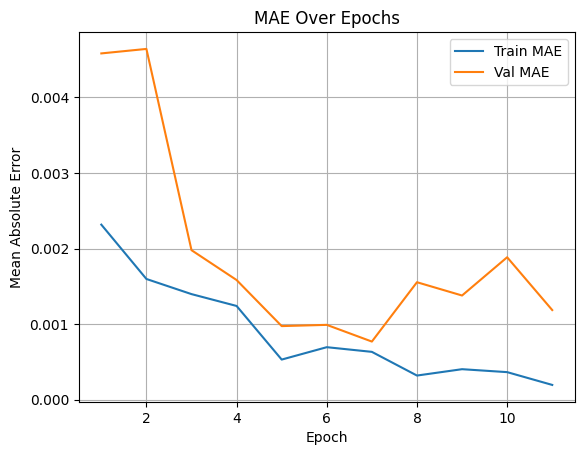

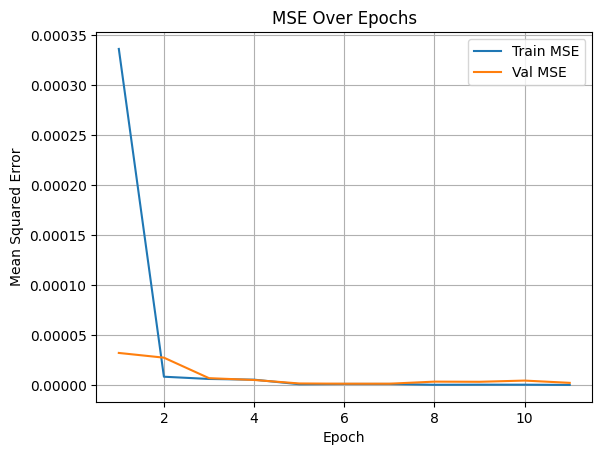

In [ ]:
# Extract metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
mse = history.history['mse'] if 'mse' in history.history else None
val_mse = history.history['val_mse'] if 'val_mse' in history.history else None

epochs_range = range(1, len(loss) + 1)

# Plot Loss
plt.figure()
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE
plt.figure()
plt.plot(epochs_range, mae, label='Train MAE')
plt.plot(epochs_range, val_mae, label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot MSE (if available)
if mse is not None and val_mse is not None:
    plt.figure()
    plt.plot(epochs_range, mse, label='Train MSE')
    plt.plot(epochs_range, val_mse, label='Val MSE')
    plt.title('MSE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

### 8: Plot Predictions

792/792 ━━━━━━━━━━━━━━━━━━━━ 71s 89ms/step


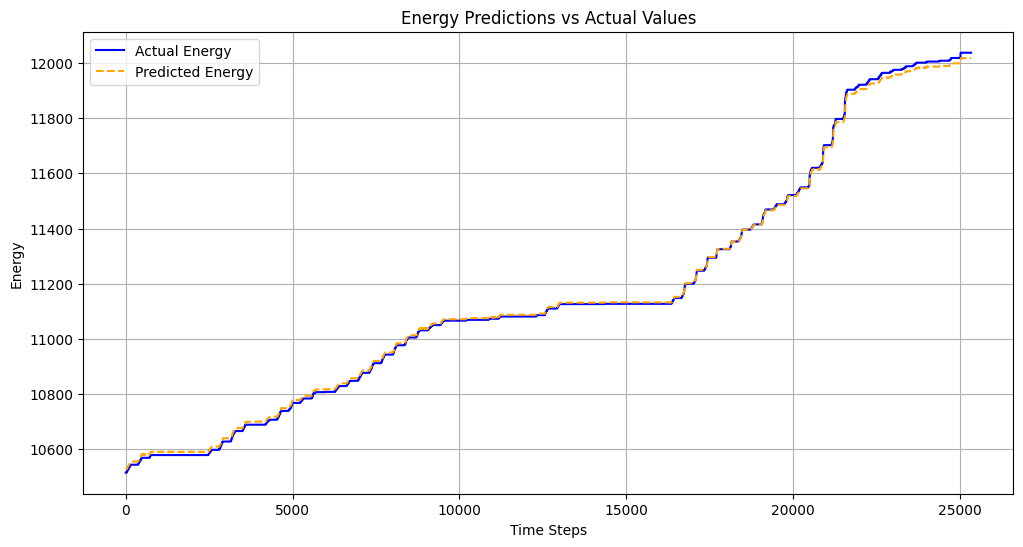

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot energy predictions (first feature)
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 0], label='Actual Energy', color='blue')
plt.plot(y_pred_inv[:, 0], label='Predicted Energy', color='orange', linestyle='--')
plt.title('Energy Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()